# Libraries

In [1]:
# pip install Unidecode
# !pip install datashader
# !pip install geopandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tqdm
from unidecode import unidecode

In [3]:
import sys
import os

# File path to the src directory for both linux and windows
# workaround for the issue of relative imports in Jupyter notebooks to import modules from src without using the full path
src_path = os.path.abspath("src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

In [3]:
# Rerun this cell after making changes to the utils module
from the_team.utils import etl
from the_team.utils import viz
import importlib
importlib.reload(etl)

# Set custom plot style for consistency
etl.set_plot_style()

Custom plot style set.


/home/home/miniconda3/envs/tf-rocm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Before Cleaning

In [5]:
RAW_DIR = Path("data") / "01_raw"

In [5]:
# Load datasets
customers = etl.load_csv(RAW_DIR / "olist_customers_dataset.csv")
geolocation = etl.load_csv(RAW_DIR / "olist_geolocation_dataset.csv")
items = etl.load_csv(RAW_DIR / "olist_order_items_dataset.csv")
payments = etl.load_csv(RAW_DIR / "olist_order_payments_dataset.csv")
reviews = etl.load_csv(RAW_DIR / "olist_order_reviews_dataset.csv")
orders = etl.load_csv(RAW_DIR / "olist_orders_dataset.csv")
products = etl.load_csv(RAW_DIR / "olist_products_dataset.csv")
sellers = etl.load_csv(RAW_DIR / "olist_sellers_dataset.csv")
translation = etl.load_csv(RAW_DIR / "product_category_name_translation.csv")

### Geolocation-related datasets [Jin Bin]
- customers.csv
- geolocation.csv
- sellers.csv

#### customers.csv

In [7]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [8]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [9]:
# Check for duplicates
etl.null_duplicate_check(customers)

No null values found.
No duplicates found.


In [10]:
# Data formatting
formatted_customers = etl.format_customers(customers)

In [11]:
# Min seems low but its not a problem 
formatted_customers.describe()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441,99441,99441
unique,99441,96096,14994,4119,27
top,274fa6071e5e17fe303b9748641082c8,8d50f5eadf50201ccdcedfb9e2ac8455,22790,sao paulo,SP
freq,1,17,142,15540,41746


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

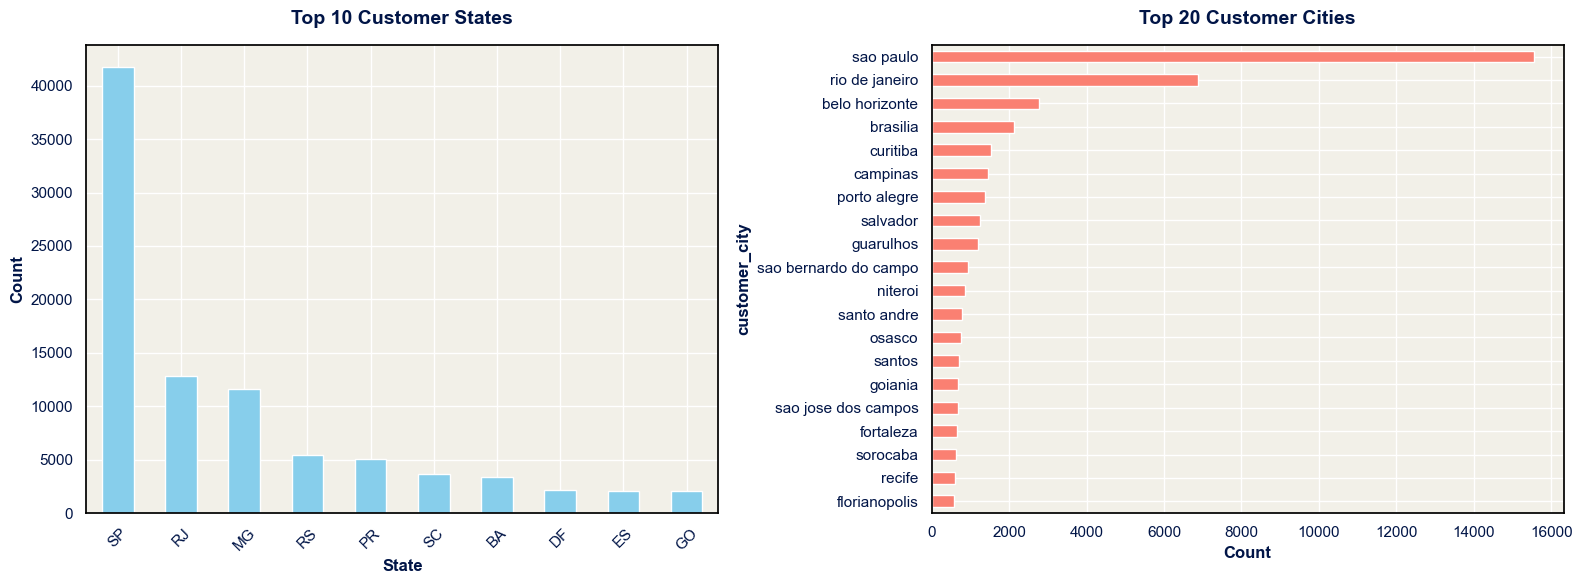

In [12]:
viz.plot_top_locations(formatted_customers, title_prefix="Customer")

1. Strong Regional Concentration.(SP) dominates customer count with over 40,000 customers — nearly half of the data. This suggests regional market dependence so if Olist wants to target repeat buyers, SP should be a priority.

2. Urban Centers Drive Volume. Cities like São Paulo, Rio de Janeiro, and Belo Horizonte are far ahead of others. (Urban hubs = higher density = possibly faster repeat behavior.) --> we could analyze if urban customers reorder more frequently due to better delivery coverage or seller availability after taking sellers.csv into account.

#### geolocation.csv

In [13]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


The geolocation dataset contains multiple similar latitude and longitude entries for the same zip code prefix. To simplify the data and enable efficient merging with customer and seller datasets, we averaged the latitude and longitude for each unique zip code prefix. While this reduces geographic precision, it preserves regional location context needed for distance-based analysis in later stages.

In [14]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [15]:
#checks for duplicates
etl.null_duplicate_check(geolocation)

No null values found.
Duplicates found.
26.18% or 261831 rows are complete duplicates.
         geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                               1037       -23.545621       -46.639292   
1                               1046       -23.546081       -46.644820   
2                               1046       -23.546129       -46.642951   
6                               1047       -23.546273       -46.641225   
7                               1013       -23.546923       -46.634264   
...                              ...              ...              ...   
1000153                        99970       -28.343273       -51.873734   
1000154                        99950       -28.070493       -52.011342   
1000159                        99900       -27.877125       -52.224882   
1000160                        99950       -28.071855       -52.014716   
1000162                        99950       -28.070104       -52.018658   

        geolocation_city

In [16]:
formatted_geolocation = etl.format_geolocation(geolocation)
formatted_geolocation.describe()

,geolocation_lat,geolocation_lng
count,19015.000000,19015.000000
mean,-19.054528,-46.057051
std,7.297050,5.367748
min,-33.689824,-72.916069
25%,-23.564158,-49.002485
50%,-22.418164,-46.632063
75%,-15.608744,-43.255602
max,42.184003,121.105394


max lat/lng values are a little suspicious cause the borders of brazil are not that big
- lat range should be between 33.75116944 and 5.27438888
- lng range should be between -73.98283055 and -34.79314722

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

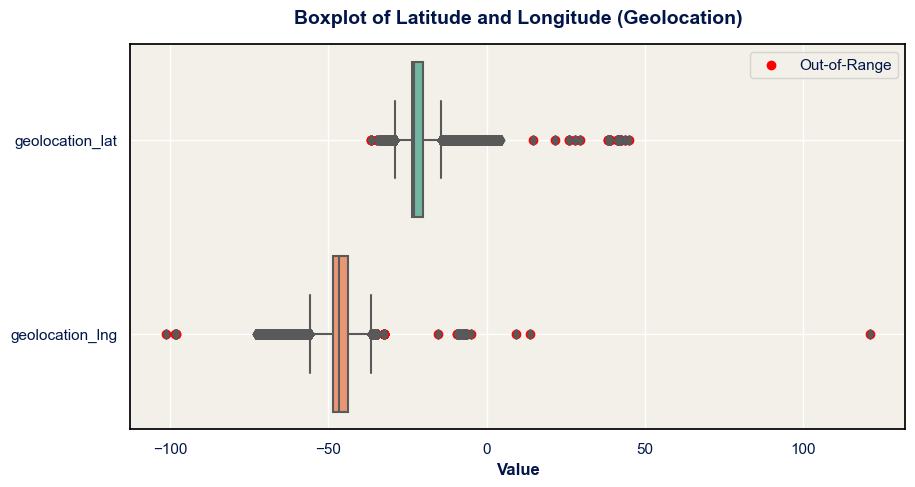

In [ ]:
# Defining Brazil's boundary conditions
valid_lat_range = (-33.75116944, 5.27438888)
valid_lng_range = (-73.98283055, -34.79314722)

# Prepare data
lat_outliers = geolocation[
    (geolocation["geolocation_lat"] < valid_lat_range[0]) |
    (geolocation["geolocation_lat"] > valid_lat_range[1])
]["geolocation_lat"]

lng_outliers = geolocation[
    (geolocation["geolocation_lng"] < valid_lng_range[0]) |
    (geolocation["geolocation_lng"] > valid_lng_range[1])
]["geolocation_lng"]

# Plot base boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(data=geolocation[["geolocation_lat", "geolocation_lng"]], orient="h", palette="Set2")

# Overlay red dots for out-of-bound lat/lng
plt.scatter(lat_outliers, ["geolocation_lat"] * len(lat_outliers), color="red", label="Out-of-Range")
plt.scatter(lng_outliers, ["geolocation_lng"] * len(lng_outliers), color="red")

plt.title("Boxplot of Latitude and Longitude (Geolocation)")
plt.xlabel("Value")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Removing the outlier Lat/Lng values 
# Filter only valid rows
geolocation = geolocation[
    (geolocation["geolocation_lat"].between(*valid_lat_range)) &
    (geolocation["geolocation_lng"].between(*valid_lng_range))
]

# Check if any outliers remain
print(f"Remaining rows: {len(geolocation)}")
geolocation.describe()

Remaining rows: 1000121


,geolocation_lat,geolocation_lng
count,1.000121e+06,1.000121e+06
mean,-2.117779e+01,-4.639142e+01
std,5.707716e+00,4.260789e+00
min,-3.369262e+01,-7.293075e+01
25%,-2.360355e+01,-4.857322e+01
50%,-2.291941e+01,-4.663789e+01
75%,-1.997985e+01,-4.376810e+01
max,4.482242e+00,-3.479369e+01


will be merged with customers.csv and sellers.csv to plot a map for the distribution of sellers and customers. Could also be used to calculate distance between the 2 groups.

#### sellers.csv

In [20]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [21]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [22]:
#check for duplicates
etl.null_duplicate_check(sellers)

No null values found.
No duplicates found.


In [ ]:
formatted_sellers = etl.format_sellers(sellers)

In [35]:
formatted_sellers.describe()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
count,3095,3095,3095,3095
unique,3095,2246,609,23
top,9e25199f6ef7e7c347120ff175652c3b,14940,sao paulo,SP
freq,1,49,695,1849


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

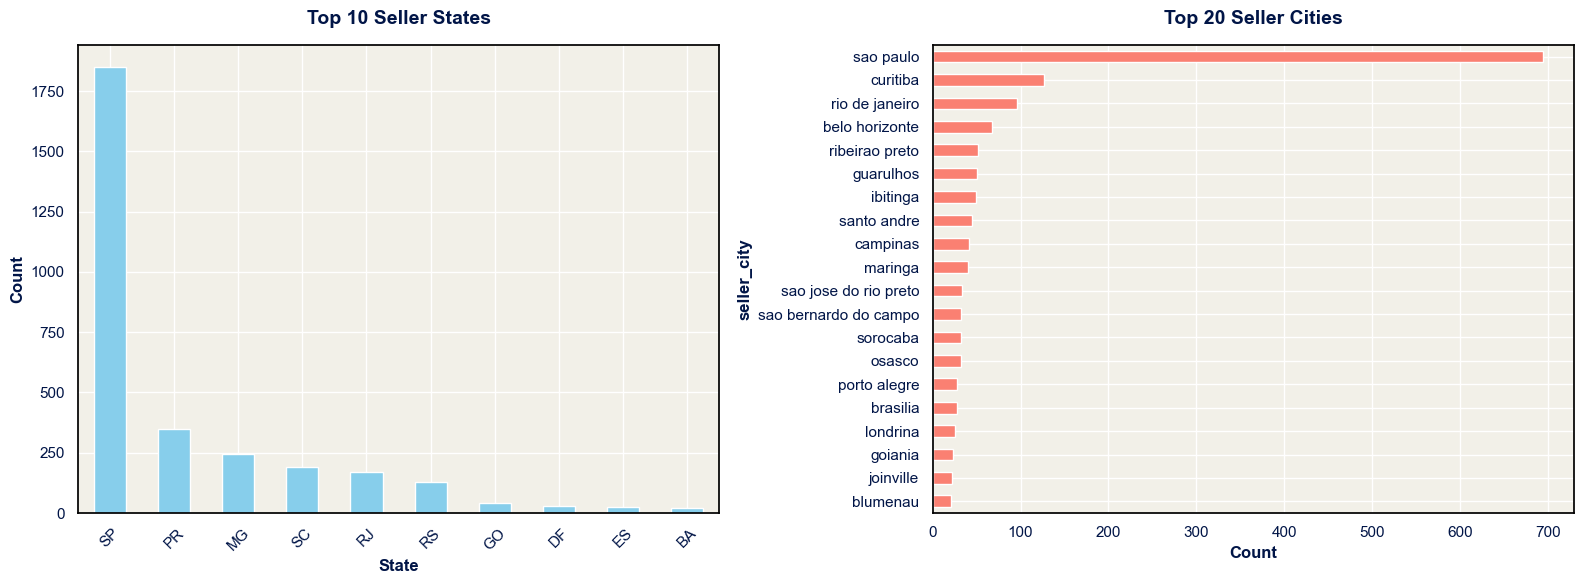

In [36]:
viz.plot_top_locations(formatted_sellers, 
                   state_col="seller_state", 
                   city_col="seller_city", 
                   title_prefix="Seller")


Customer and seller geographic distribution shows strong overlap in urban regions such as São Paulo and Rio de Janeiro. This urban concentration, combined with higher seller density, could facilitate quicker deliveries and higher satisfaction—factors known to influence repeat buying behavior.

### Review-related datasets [Habib]
- review.csv
- products.csv
- translation.csv

#### Review dataset


In [6]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [7]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [8]:
# .info shows missing entries
etl.null_duplicate_check(reviews)

Null values found.
90.08% or 89385 rows have 1 or more null values.
Null value counts per column:
review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64
No duplicates found.


In [6]:
# Step 1) Since many users about 90% did not give their comments a title I will drop the title column as the data is not complete enough, the review date/timestamp are not relevant as 
# there is no time aspect in this situation so that will be dropped as well. The Review Id is also not required as its just used to index the reviews and this is not relevant.

reviews.drop(columns=["review_id", "review_comment_title","review_creation_date", "review_answer_timestamp"], inplace=True)

reviews.head()

# Dataset is now less bloated and only relevant columns remain.

,order_id,review_score,review_comment_message
0,73fc7af87114b39712e6da79b0a377eb,4,NaN
1,a548910a1c6147796b98fdf73dbeba33,5,NaN
2,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN
3,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...


/home/home/Study/AI Solution Development/Project/THE_TEAM-AISD/src/the_team/utils/viz.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=column, palette="husl", order=ordered_vals)
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font fam

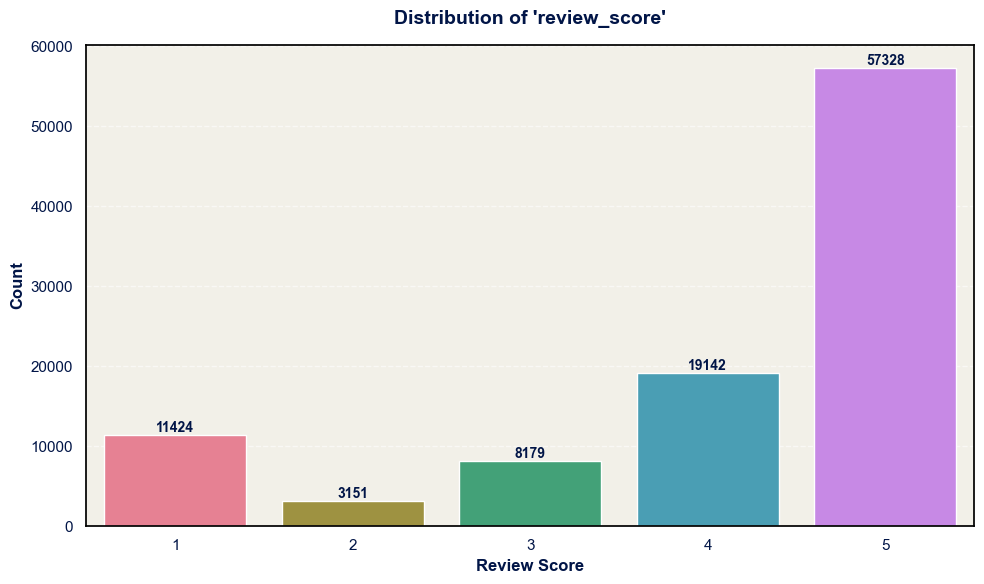

In [ ]:
# Lets take a look at the spread of the review scores before any validation.

viz.plot_categorical_distribution(reviews, "review_score")

# FIXME: Matplotlib is raising findfont warnings due to missing Arial/Helvetica
# We can consider replacing with 'DejaVu Sans' or updating the font config.

- We can see that there is a large bias towards 5 & 4 point reviews suggesting about 1 in 3 orders are satisfactory and leave a posititve impression on the end user.
- However there is a large amount of neutral reviews. To prevent non useful datapoints, this will be checked against the sentiment of the comments to verify all ratings are as intended.

#### Products dataset

In [11]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [12]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [ ]:
# .info shows small amount of missing entries
etl.null_duplicate_check(products)

Null values found.
1.85% or 611 rows have 1 or more null values.
Null value counts per column:
product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64
No duplicates found.


In [ ]:
# 2) There is no possible way to feature engineer or substitute placeholder values for any of the columns so I will drop any df row with no data entries

products.dropna(inplace=True)

etl.null_duplicate_check(products)

# No further actions with this dataset as I will use the data to figure out if product category and size have an effect on user satisfaction so all columns are relevant

No null values found.
No duplicates found.


#### Translation Dataset

In [14]:
translation.head()
# From what I can see, this is a small dataset for end users to translate the portuguese labeled items.

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [ ]:
translation.info()
# There are no missing or duplicate values. Nor any further visualisations, so I will leave this dataset as is and may use it in the future for sentiment analysis of product categories.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


### Order-related datasets [Min]
- items.csv
- payments.csv
- orders.csv

#### items.csv

In [25]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [26]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [27]:
# df info says no Null but still; Null and duplicate check
etl.null_duplicate_check(items)

No null values found.
No duplicates found.


In [28]:
# 1. shipping_limit_date has wrong data type.
items["shipping_limit_date"] = pd.to_datetime(items["shipping_limit_date"], format="%Y-%m-%d %H:%M:%S")
assert items["shipping_limit_date"].dtype == "datetime64[ns]", "shipping_limit_date should be datetime64[ns]"

# 2. order_id has wrong data type, but it's not useful for our business goal since it's just indexing items in an order.
# Thus, we can drop it.
items.drop(columns=["order_item_id"], inplace=True)

# Some duplicates are expected after dropping order_item_id, since there can be multiple items in an order.
# Left untreated as these duplicates are identifiable and workable with the order_id.
etl.null_duplicate_check(items)

No null values found.
Duplicates found.
9.08% or 10225 rows are complete duplicates.
                                order_id                        product_id  \
13      0008288aa423d2a3f00fcb17cd7d8719  368c6c730842d78016ad823897a372db   
14      0008288aa423d2a3f00fcb17cd7d8719  368c6c730842d78016ad823897a372db   
32      00143d0f86d6fbd9f9b38ab440ac16f5  e95ee6822b66ac6058e2e4aff656071a   
33      00143d0f86d6fbd9f9b38ab440ac16f5  e95ee6822b66ac6058e2e4aff656071a   
34      00143d0f86d6fbd9f9b38ab440ac16f5  e95ee6822b66ac6058e2e4aff656071a   
...                                  ...                               ...   
112635  fff8287bbae429a99bb7e8c21d151c41  bee2e070c39f3dd2f6883a17a5f0da45   
112640  fffb9224b6fc7c43ebb0904318b10b5f  43423cdffde7fda63d0414ed38c11a73   
112641  fffb9224b6fc7c43ebb0904318b10b5f  43423cdffde7fda63d0414ed38c11a73   
112642  fffb9224b6fc7c43ebb0904318b10b5f  43423cdffde7fda63d0414ed38c11a73   
112643  fffb9224b6fc7c43ebb0904318b10b5f  43423cdffde7fda

In [29]:
# Check distribution of numeric columns
items.describe()

,shipping_limit_date,price,freight_value
count,112650,112650.000000,112650.000000
mean,2018-01-07 15:36:52.192685312,120.653739,19.990320
min,2016-09-19 00:15:34,0.850000,0.000000
25%,2017-09-20 20:57:27.500000,39.900000,13.080000
50%,2018-01-26 13:59:35,74.990000,16.260000
75%,2018-05-10 14:34:00.750000128,134.900000,21.150000
max,2020-04-09 22:35:08,6735.000000,409.680000
std,NaN,183.633928,15.806405


- A large gap between the 75th percentile (Q3) and the maximum indicates that there are high-value outliers. 
- Olist dataset distributor mentioned (in Kaggle) that the data is from 2016 to 2018.

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

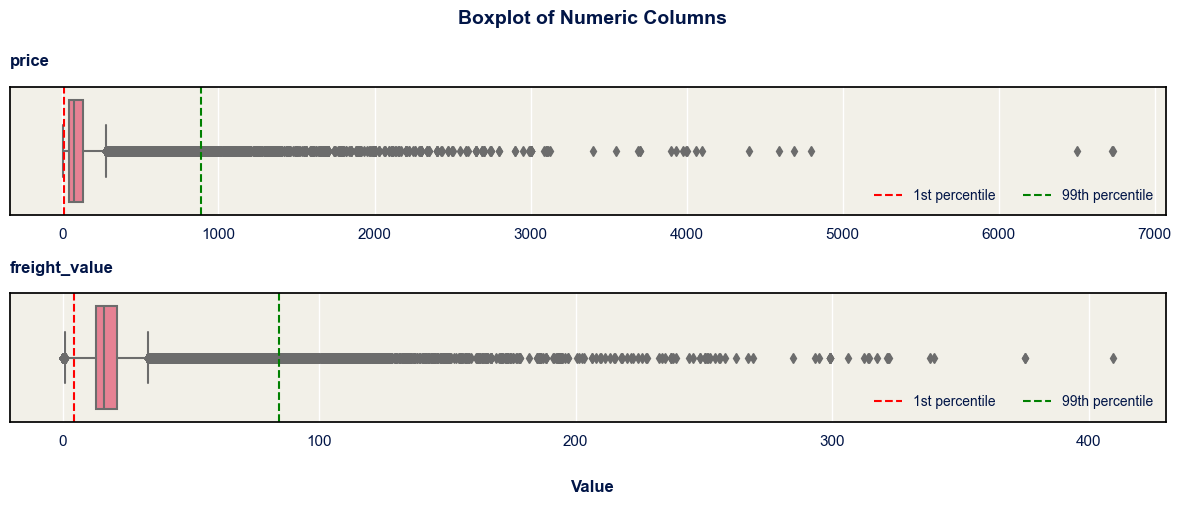

In [30]:
# 3. Drop rows not within 2016-2018
items = items[items["shipping_limit_date"].dt.year.isin([2016, 2017, 2018])]

# Plot distribution of numeric columns
etl.plot_numeric_distribution(items)

- Both price & freight_value columns show strong right-skewed distributions with a large number of high-value outliers, which is expected as people mostly buy FMCGs (with low cost) from online, not high-end products.
- Right-skewed price means the item is expensive while right-skewed freight_value means either the customer lives far away from sellers or the item is physically huge; this can be cross-checked later with geolocation and product data.

In [31]:
price_99p = items['price'].quantile(0.999)
print(f"99.9% of price is ${price_99p}.")
freight_99p = items['freight_value'].quantile(0.999)
print(f"99.9% of freight_value is ${freight_99p:.2f}.")

99.9% of price is $2110.0.
99.9% of freight_value is $175.59.


High values in both price and freight_value are important as they may suggest:
- People who bought expensive quality producuts are less likely to buy again. 
- People who have to pay high freight_value are less likely to buy again. 
But, capturing 99.9% of current customers should be representative enough. 

In [32]:
# 4. Remove outliers
items['price'] = etl.cap_outliers(items['price'], min_cap=False, max_cap=99.9)
items['freight_value'] = etl.cap_outliers(items['freight_value'], min_cap=False, max_cap=99.9)

In [33]:
# 5. Flag high values for the model to learn that a price/freight is unusually high
items['price_high'] = items['price'] > price_99p
items['freight_value_high'] = items['freight_value'] > freight_99p

#### orders.csv